1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Predicted: [('n03450230', 'gown', 0.19088568), ('n03534580', 'hoopskirt', 0.07605634), ('n03424325', 'gasmask', 0.054620285)]


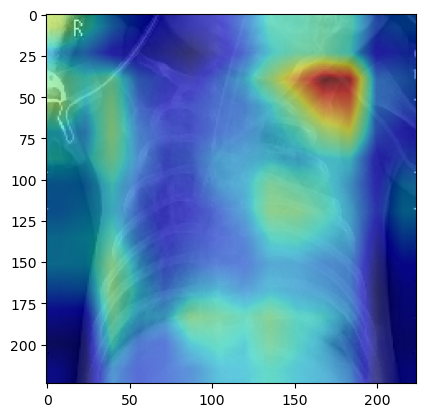

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import cv2

#original CNN model D:\sem5\MLinHealthCare\ML4H_git\Project1\code\integrated_gradients\our_model.pth
#model with random targets - 70 percent randomization: D:\sem5\MLinHealthCare\ML4H_git\Project1\code\integrated_gradients\our_model_70p_random.pth

def get_grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    output = conv_output[0]
    grads = tape.gradient(loss, conv_output)[0]

    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.dot(output, weights)

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    return heatmap

def get_grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(model.inputs, [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    output = conv_output[0]
    
    # Convert img_array to a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img_array)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        conv_output, predictions = grad_model(img_tensor)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)[0]
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.dot(output, weights)

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    return heatmap

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Choose an image from your dataset
img_path = '../data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get the predictions for the image
preds = model.predict(x)
decoded_preds = decode_predictions(preds, top=3)[0]
print('Predicted:', decoded_preds)

# Choose the layer name from which you want to compute Grad-CAM
layer_name = 'block5_conv3'

# Get Grad-CAM heatmap
heatmap = get_grad_cam(model, x, layer_name)

# Overlay heatmap on the original image
plt.imshow(img)
plt.imshow(heatmap, alpha=0.5, cmap='jet')
plt.show()


In [3]:
!pip install torch-summary

  Using cached torch_summary-1.4.5-py3-none-any.whl.metadata (18 kB)
Using cached torch_summary-1.4.5-py3-none-any.whl (16 kB)


### pytorch implementation

Predicted class: 0


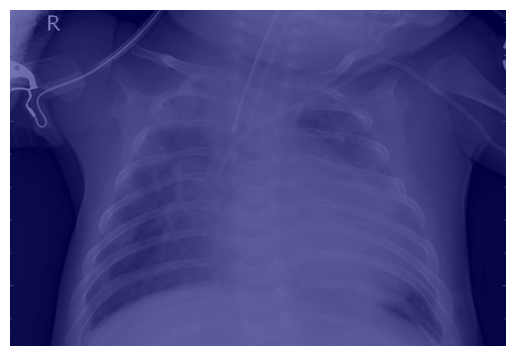

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import cv2  # Added import for cv2

# Define your model class
class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        # Define your model architecture here

    def forward(self, x):
        # Define the forward pass of your model
        return x

def load_model(model_path):
    model = models.resnet18(pretrained=True)  # Corrected parameter name to pretrained
    model.fc = nn.Linear(512, 2)  # Change the last fully connected layer for binary classification
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Load the pre-trained weights
    model.eval()
    return model

def get_grad_cam(model, img_tensor, target_layer_name):
    # Define a forward hook to extract activations from the target layer
    activations = {}
    def hook_fn(module, input, output):
        activations[target_layer_name] = output
    hook = model._modules.get(target_layer_name).register_forward_hook(hook_fn)
    
    # Forward pass to compute the output and activations
    output = model(img_tensor)
    target_activations = activations[target_layer_name].detach().squeeze(0).requires_grad_(True)
    
    # Compute the gradients of the output with respect to the target activations
    gradients = torch.autograd.grad(outputs=output, inputs=target_activations, grad_outputs=torch.ones_like(output), retain_graph=True, allow_unused=True)[0]
    
    # Check if gradients are not None
    if gradients is not None:
        # Compute the Grad-CAM heatmap
        weights = F.adaptive_avg_pool2d(gradients, 1)
        heatmap = torch.sum(weights * target_activations, dim=0).cpu().detach().numpy()  # Use detach().numpy() instead of numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
    else:
        # If gradients are None, return a zero heatmap
        heatmap = np.zeros_like(activations[target_layer_name][0][0].cpu().detach().numpy())  # Use detach().numpy() instead of numpy()
    
    # Remove the forward hook
    hook.remove()
    
    return heatmap

# Load your PyTorch model
model_path = '../code/integrated_gradients/our_model.pth'
model = load_model(model_path)
# print(summary(model, (3, 224, 224)))  # Removed summary print as summary function is not defined

# Load your PyTorch model on the GPU
model = load_model(model_path).cuda()

# Choose an image from your dataset
img_path = '../data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'
img = Image.open(img_path).convert('RGB')

# Define transformations to prepare the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Prepare the input image as a tensor and move it to the GPU
img_tensor = transform(img).unsqueeze(0).cuda()

# Choose the target layer name from which you want to compute Grad-CAM
target_layer_name = 'layer4'

# Forward pass to get the prediction
with torch.no_grad():
    output = model(img_tensor)

# Get the predicted class
predicted_class = torch.argmax(output).item()
print("Predicted class:", predicted_class)

# Get Grad-CAM heatmap
heatmap = get_grad_cam(model, img_tensor, target_layer_name)

# Resize the heatmap to match the image size
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = np.uint8(255 * heatmap)

# Overlay heatmap on the original image
heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap_on_image = cv2.addWeighted(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), 0.5, heatmap_colored, 0.5, 0)

# Display the original image with overlaid heatmap
plt.imshow(cv2.cvtColor(heatmap_on_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()